Machine learning often involves optimization, that is solving

$$\arg\min_{x} f(x),\ f: \mathbb{R}^n \rightarrow \mathbb{R},$$

where $f(x)$ is an objective function, for example, [negative log-likelihood](http://alexanderfabisch.github.io/maximum-likelihood.html).

Often you cannot find the optimum directly. That is the reason why we need numerical, iterative optimization methods. I will take a closer look at these methods that are the fundamentals of machine learning but we need some basic tools first.

## Minimizing Quadratic Functions

Optimizing quadratic functions is the simplest case.

A general quadratic function has the form

$$\arg\min x^T A x + b^T x + c,\ A \in \mathbb{R}^{n \times n}, b \in \mathbb{R}^n, c \in \mathbb{R}$$

By the way, we can approximate functions locally with a quadratic Taylor expansion.

### Elementary Rules of Matrix Differentiation

Similar to [elementary rules of differentiation](https://en.wikipedia.org/wiki/Differentiation_rules#Elementary_rules_of_differentiation), there are several rules for differentiation with matrices and vectors:

* $\nabla \left[ f(x) + g(x) \right] = \nabla f(x) + \nabla g(x)$
* $\nabla x^T A x = x^T (A + A^T) = (A + A^T) x$, if $A$ is symmetric: $\nabla x^T A x = 2 x^T A = 2 A x$
* $\nabla x^T A = A$
* $\nabla b^T x = b$

You can find these rules in [The Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf). Capital letters usually denote matrices (A) here and small letters are vectors (x, b), functions (f, g) or scalars (c).

A quadratic function has the following derivatives:

* Gradient: $\nabla x^T A x + b^T x + c = (A + A^T) x + b$
* Hessian matrix: $\nabla \nabla x^T A x + b^T x + c = A + A^T$

$A + A^T$ is a symmetric matrix because $(A + A^T)_{ij} = A_{ij} + A_{ji} = A_{ji} + A_{ij} = (A + A^T)_{ji}$ for all pairs of $i$ and $j$. You could come to the same conclusion if you see that [Schwarz's theorem](https://en.wikipedia.org/wiki/Symmetry_of_second_derivatives#Schwarz.27s_theorem) applies.

If the Hessian is [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix), that is $x^T(A + A^T)x > 0$ for all $x$ (or: it has only positive eigenvalues), then the quadratic function is convex and has a unique minimum. If it is negative definite, it is concave and has a unique maximum. Let us assume the Hessian is positive definite and we can minimize it.

Optimization is closely connected to root finding. We can find optima where $\nabla f(x) = 0$, that is, we have to find the roots of the gradient.

For quadratic functions it is easy. The gradient has its zero at

$$0 = (A + A^T) x^* + b \Leftrightarrow x^* = -(A + A^T)^{-1}b$$

There is an "iterative" way to reach this solution from any point $x$:

\begin{eqnarray}
x^* &=& -(A + A^T)^{-1} b\\
    &=& x - x - (A + A^T)^{-1} b\\
    &=& x - (A + A^T)^{-1} (A + A^T) x - (A + A^T)^{-1} b\\
    &=& x - (A + A^T)^{-1} \left[ (A + A^T) x + b \right]\\
    &=& x - \nabla \nabla \left[ f(x) \right]^{-1} \nabla f(x)\\
\end{eqnarray}

This gives a method to reach the optimum of a quadratic function from any point $x$ if we know the gradient $\nabla f(x)$ and the Hessian $\nabla \nabla f(x)$.

Let us take a look at the following quadratic function.

In [1]:
%pylab inline
mpl.rc("font", size=20)
mpl.rc("axes", labelsize="large")

Populating the interactive namespace from numpy and matplotlib


In [2]:
def quadratic(x, A=None, b=None, c=None):
    n_dims = len(x)
    if A is None: A = np.eye(n_dims)
    if b is None: b = np.zeros(n_dims)
    if c is None: c = 0.0
    return x.dot(A).dot(x) + b.dot(x) + c

def quadratic_grad(x, A=None, b=None, c=None):
    n_dims = len(x)
    if A is None: A = np.eye(n_dims)
    if b is None: b = np.zeros(n_dims)
    if c is None: c = 0.0
    return x.dot(A + A.T) + b

def quadratic_hess(x, A=None, b=None, c=None):
    n_dims = len(x)
    if A is None: A = np.eye(n_dims)
    if b is None: b = np.zeros(n_dims)
    if c is None: c = 0.0
    return A + A.T

## Newton's method

The algorithm that we just discovered is Newton's method. It updates the parameters from some initial point with with an iterative update

$$x_{t+1} = x_t - \nabla \nabla \left[ f(x_t) \right]^{-1} \nabla f(x_t)$$

In [3]:
def newton(x0, fun, grad, hess, grad_threshold=1e-10, max_iter=100):
    n_dims = len(x0)
    x = np.copy(x0)
    path = [np.copy(x0)]

    for _ in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < grad_threshold:
            break
        H = hess(x)
        x -= np.linalg.inv(H).dot(g)

        path.append(np.copy(x))
    return x, path

Here are some helper functions that you should ignore. ;)

In [4]:
def plot_path(fun, path, scale=10):
    S, T, U = prepare_grid(fun, scale)
    fig = figure(figsize=(8, 8))
    ax = plt.subplot(111, aspect="equal")
    c = ax.contourf(
        S, T, U, cmap=plt.cm.hot,
        levels=np.linspace(np.min(U), np.max(U), 101))
    plt.colorbar(c)
    path = np.asarray(path)
    ax.plot(path[:, 0], path[:, 1], "-o")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


def prepare_grid(fun, scale):
    s = t = np.linspace(-scale, scale, 101)
    S, T = np.meshgrid(s, t)
    U = np.empty_like(S)
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            U[i, j] = fun(np.array([S[i, j], T[i, j]]))
    return S, T, U

We run it on the simplest quadratic function and, as we have just proven, the optimum (in this case a minimum) is reached in one step.

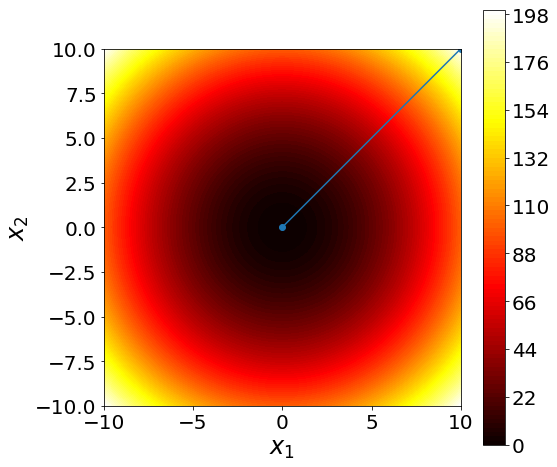

In [5]:
x0 = 10.0 * np.ones(2)
x_best, path = newton(x0, quadratic, quadratic_grad, quadratic_hess)
plot_path(quadratic, path)

It also works for more complex quadratic functions.

In [6]:
from functools import partial
A = np.array([
    [1.5, -2.5],
    [6.0, 5.2]
])
b = np.array([-3, -10.5])
c = 10.0
x0 = 10.0 * np.ones(2)
x_best, path = newton(
    x0, partial(quadratic, A=A, b=b, c=c),
    partial(quadratic_grad, A=A, b=b, c=c),
    partial(quadratic_hess, A=A, b=b, c=c))

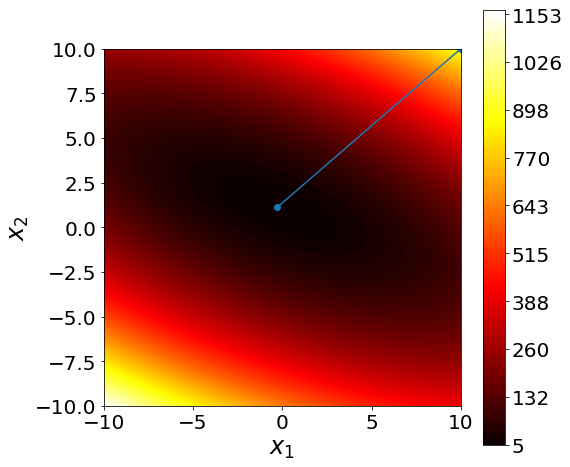

In [7]:
plot_path(partial(quadratic, A=A, b=b, c=c), path)

If you use it to minimize some other kind of function, it will really become an iterative method. Why does it work after all? The intuition behind this is that we can always compute a quadratic model of our objective function based on the evaluation for the function, gradient and Hessian at some point $a$ with a quadratic Taylor expansion:
$$f(x) \approx f(a) + (x - a)^T \nabla f(a) + \frac{1}{2} (x - a)^T \nabla \nabla f(a) (x - a)$$
We can show that this exactly reproduces the original function if $f(x)$ is quadratic but this is a little bit lengthy so I will omit that here. Note that Newton's method only finds local minima or saddle points.

For example, here we have a function that includes a sine.

In [8]:
def poly(x):
    return x[0] ** 2 - 5.0 * np.sin(x[0]) ** 4 + x[0] * x[1] ** 2
def poly_grad(x):
    return np.array([2 * x[0] - 5.0 * np.cos(x[0]) + x[1] ** 2,
                     2 * x[0] * x[1]])
def poly_hess(x):
    return np.array([[2 + 5.0 * np.sin(x[0]) ** 2, 2 * x[1]],
                     [2 * x[1], 2 * x[0]]])

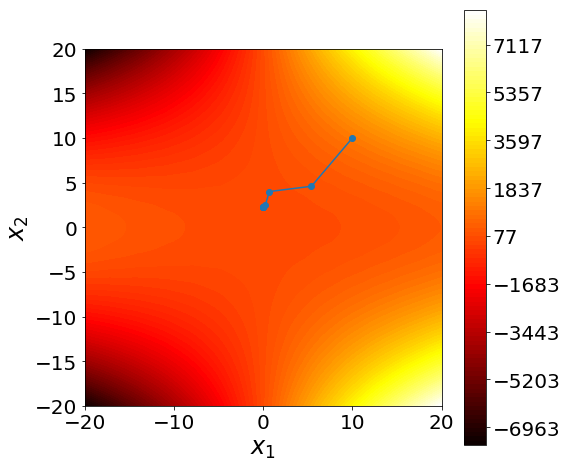

In [9]:
x_best, path = newton(x0, poly, poly_grad, poly_hess)
plot_path(poly, path, scale=20)

Another interesting function is Rosenbrock's banana function, which has a global minimum at $(1, 1)^T$.

In [10]:
def rosenbrock(x):
    return (100 * x[1] ** 2 - 200 * x[0] ** 2 * x[1] + 100 * x[0] ** 4
            + 1 - 2 * x[0] + x[0] ** 2)
def rosenbrock_grad(x):
    return np.array([-400 * x[0] * x[1] + 400 * x[0] ** 3 - 2 + 2 * x[0],
                     200 * x[1] - 200 * x[0] ** 2])
def rosenbrock_hess(x):
    return np.array([[-400 * x[1] + 1200 * x[0] ** 2 + 2, -400 * x[0]],
                     [-400 * x[0], 200]])

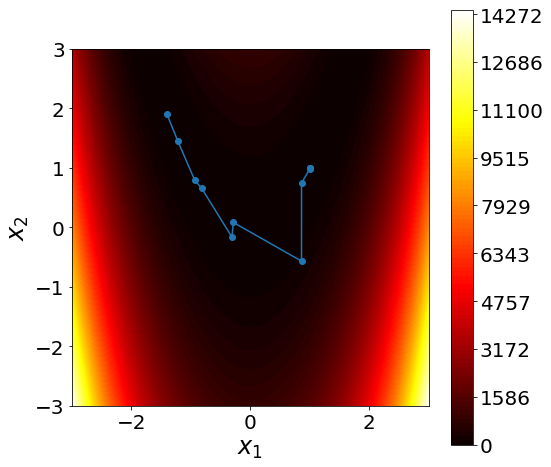

In [11]:
x0 = np.array([-1.4, 1.9])
x_best, path = newton(
    x0, rosenbrock, rosenbrock_grad, rosenbrock_hess)
plot_path(rosenbrock, path, scale=3)

Unfortunately, it does not always work. This function is a quadratic function but its Hessian is not invertible.

In [12]:
def not_invertible(x):
    return -1.0 + 2 * x[0] - 100 * x[1] + 99 * x[0] ** 2
def not_invertible_grad(x):
    return np.array([2.0 + 198.0 * x[0], -100.0])
def not_invertible_hess(x):
    return np.array([[198, 0.0], [0.0, 0.0]])

In [13]:
x0 = np.ones(2)
try:
    x_best, path = newton(
        x0, not_invertible, not_invertible_grad, not_invertible_hess)
except LinAlgError as e:
    print("got an error:")
    print(e)

got an error:
Singular matrix


## Gradient Descent

For now, let us go back to a much simpler iterative method: gradient descent. The update is computed as

$$x_{t+1} = x_t - \alpha \nabla f(x_t)$$

Instead of the Hessian that incorporates the curvature of the objective function, it just uses a learning rate $\alpha \in (0, 1]$ to scale the gradient direction.

It has another advantage if we want to optimize many parameters: it does not require the inversion of the Hessian, which has cubic complexity. Gradient descent only has linear complexity and it does not require to store the Hessian which has quadratic size.

In [14]:
def gradient_descent(x0, fun, grad, alpha,
                     grad_threshold=1e-10, max_iter=100):
    n_dims = len(x0)
    x = np.copy(x0)
    path = [np.copy(x0)]

    for _ in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < grad_threshold:
            break
        x -= alpha * g

        path.append(np.copy(x))
    return x, path

It works but it is not very fast.

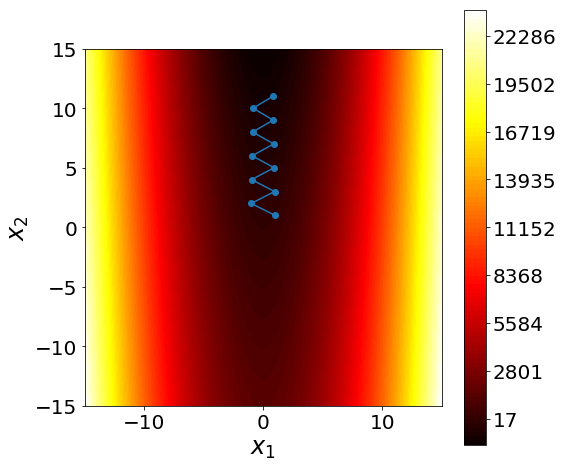

In [15]:
x0 = np.ones(2)
x_best, path = gradient_descent(
    x0, not_invertible, not_invertible_grad, 0.01, max_iter=10)
plot_path(not_invertible, path, scale=15)

Sometimes you even need thousands of steps because you have to choose a small learning rate. In this example, we need about 3500 iterations to reach the optimum.

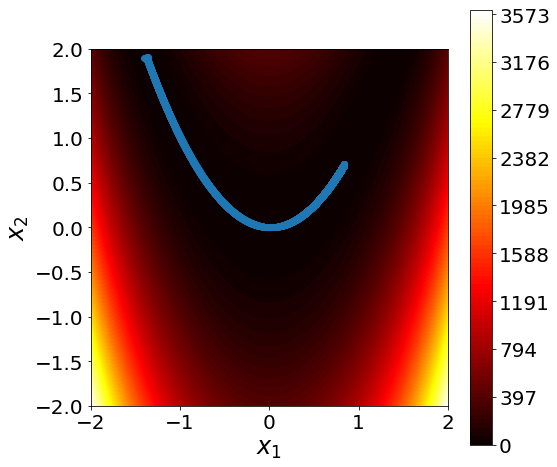

In [16]:
x0 = np.array([-1.4, 1.9])
x_best, path = gradient_descent(
    x0, rosenbrock, rosenbrock_grad, 0.001, max_iter=3500)
plot_path(rosenbrock, path, scale=2)

If the learning rate is just slightly larger, the gradient will increase too quickly and the algorithm with diverge.

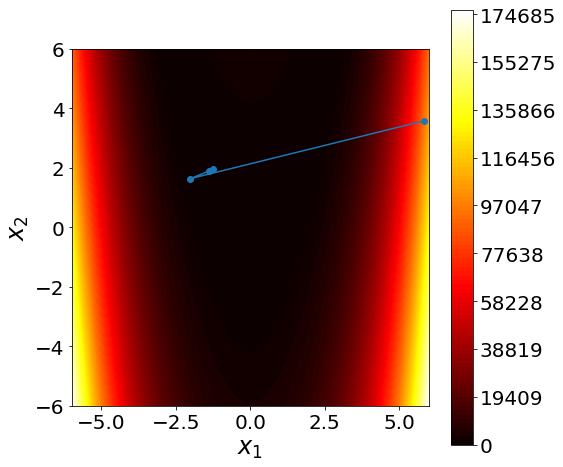

In [17]:
x0 = np.array([-1.4, 1.9])
x_best, path = gradient_descent(
    x0, rosenbrock, rosenbrock_grad, 0.004, max_iter=3)
plot_path(rosenbrock, path, scale=6)

## Broyden-Fletcher-Goldfarb-Shanno

We can do better than that. There are ways to iteratively approximate the Hessian just from gradients. These methods are called quasi-Newton methods. One of them is [Broyden-Fletcher-Goldfarb-Shanno](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). It also keeps the symmetry and positive definiteness of the approximated Hessian. Hence, we should not get any problems when inverting it.

Starting with $B_0 = I$, we can iteratively update the approximation of the Hessian $B_t$:

$$B_{t+1} = B_t + \frac{y_t y_t^T}{y_t^Ts_t} - \frac{B_ts_ts_t^TB_t}{s_t^TB_ts_t}$$

where
* $y_t = \nabla f(x_{t+1}) - \nabla f(x_t)$ is computed based on the last change of gradients
* $s_t = \alpha_t p_t$ is the last step
* $p_t$ is the search direction and the solution to the system of linear equations $B_t p_t = -\nabla f(x_t)$
* $\alpha_k > 0$ is a stepsize, which we will set manually for now

### Update Step

Before the estimate of the Hessian matrix is updated, the new estimate of $x$ is computed as
$$x_{t+1} = x_t + s_t,$$
that is, $s_t = x_{t+1} - x_t$, which we will use later.

Why do we determine the search direction by solving $B_t p_t = -\nabla f(x_t)$? From Newton's method we know that $$p_t = -B_t^{-1}\nabla f(x_t)$$ solves quadratic optimization problems in one step if $B_t$ is the real Hessian matrix. Multiplying both sides of the equation with $B_t$ yields formulation as a linear system of equations.

If we would not update $B_t$ and set it to $I$, this algorithm reduces to gradient descent. Let us take a look at the reasoning behind the Hessian approximation
$$B_{t+1} = B_t + \frac{y_t y_t^T}{y_t^Ts_t} - \frac{B_ts_ts_t^TB_t}{s_t^TB_ts_t}$$

### Secant Condition

Let us start with finite differences. We know that gradients can be approximated locally with finite differences, that is, in a point $x_2$, we can approximate
$$\nabla f(x_2) \approx \frac{f(x_2) - f(x_1)}{x_2 - x_1}$$
because $\nabla f(x_2) = \lim_{x_1 \rightarrow x_2} \frac{f(x_2) - f(x_1)}{x_2 - x_1}$.

<img src="http://www.informatik.uni-bremen.de/~afabisch/files/finite_differences.svg"/>

For functions with one parameter, we can easily use this to estimate the second derivative with
$$\nabla \nabla f(x_2) \approx \frac{\nabla f(x_2) - \nabla f(x_1)}{x_2 - x_1}$$

**Side Note: Gradient, Jacobian, Hessian**

Before we continue: notice that the objective function $f$ is a univariate function, hence it has a gradient $\nabla f(x)$. The extension of a gradient to multivariate functions is a Jacobian matrix. The Jacobian matrix contains gradients for each dimension of a function in its rows. Furthermore, the gradient of the function $f$ is a multivariate function on its own, hence, its derivative is a Jacobian matrix. The Jacobian matrix of $\nabla f(x)$ is the Hessian matrix $\nabla \nabla f(x)$ and the Hessian matrix is usually a symmetric matrix.

We can easily extend this equations to multiple dimensions and we can come back to our original notation:
$$\nabla \nabla f(x_t) \approx B_{t+1} = \frac{\nabla f(x_{t+1}) - \nabla f(x_t)}{x_{t+1} - x_t} = \frac{y_t}{s_t}$$

We can rewrite this to
$$B_{t+1} s_t = y_t,$$
which is called the secant condition. We can solve this for $B_{t+1}$ but we have more unknown parameters in $B_{t+1}$ than equations defined in this system of equations. BFGS defines further conditions for $B_{t+1}$. A constraint optimization problem is defined: the distance to the previous approximation should be minimized, that is, $\arg\min_B ||B^{-1} - B_t^{-1}||$, subject to $B = B^T$ and $Bs_t = y_t$. The solution to this optimization problem is the BFGS formula.

In [18]:
def bfgs_without_linesearch(
        x0, fun, grad, alpha, grad_threshold=1e-10, max_iter=100):
    x = np.copy(x0)
    path = [np.copy(x0)]

    n_dims = x.shape[0]
    B = np.eye(n_dims)

    g = grad(x)
    for _ in range(max_iter):
        p = np.linalg.solve(B, -g)

        s = alpha * p
        x += s

        prev_g = g
        g = grad(x)
        if np.linalg.norm(g) <= grad_threshold:
            break

        if prev_g is not None:
            y = g - prev_g
            B += (np.outer(y, y) / np.dot(y, s) -
                  B.dot(s[:, np.newaxis]).dot(s[np.newaxis, :]).dot(B)
                  / s.dot(B).dot(s))

        path.append(np.copy(x))

    return x, path

One note on the implementation: it is not the most efficient implementation. A more efficient implementation directly estimates the inverse of the Hessian. That saves us solving the linear system of equations to determine the search direction. This implementation has cubic complexity. The best implementation would have quadratic complexity.

With BFGS we can handle the problematic function:

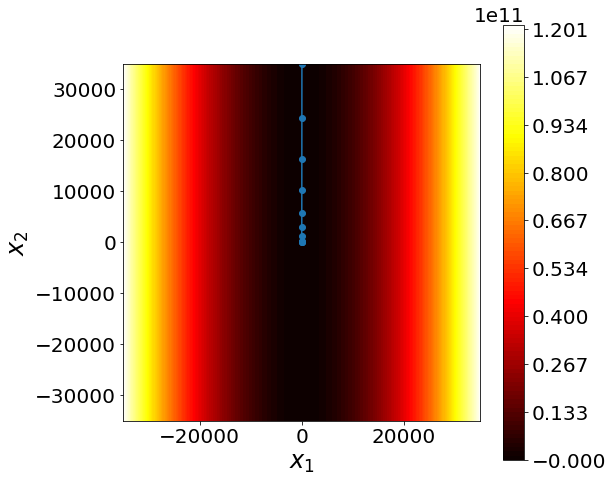

In [19]:
x0 = np.ones(2)
x_best, path = bfgs_without_linesearch(
    x0, not_invertible, not_invertible_grad, 0.01, max_iter=10)
plot_path(not_invertible, path, scale=35000)

It still has some problems though. Consider the following example with the Rosenbrock function. It often either shoots over the valley in the beginning or it moves too slowly.

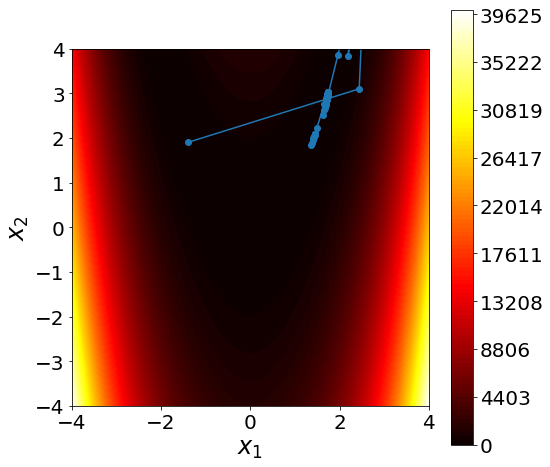

In [20]:
x0 = np.array([-1.4, 1.9])
x_best, path = bfgs_without_linesearch(
    x0, rosenbrock, rosenbrock_grad, 0.1)
plot_path(rosenbrock, path, scale=4)
_ = plt.ylim((-4, 4))

That is the reason why BFGS is usually combined with **line search**.

### Side Note: DFP Formula

There is also a very similar method that estimates the inverse of the Hessian directly, called [Davidon-Fletcher-Powell](https://en.wikipedia.org/wiki/Davidon%E2%80%93Fletcher%E2%80%93Powell_formula) (DFP):
$$B_t^{-1} = B_t^{-1} + \frac{s_t s_t^T}{s_t^Ty_t} - \frac{B_t^{-1}y_ty_t^TB_t^{-1}}{y_t^TB_t^{-1}y_t},$$
notice that only $s_t$ and $y_t$ are interchanged. This method has been invented before BFGS and is a result of a very similar optimization problem like the one that results in the BFGS update formula for the approximation of the Hessian. The only difference is that instead of minimizing the distance between the inverse of the approximation, it minimizes the distance of the approximation directly. DFP is considered inferior to BFGS.

Just to demonstrate that DFP also works, I will show it here. It usually takes much small steps in these examples though.

In [21]:
def dfp_without_linesearch(
        x0, fun, grad, alpha, grad_threshold=1e-10, max_iter=100):
    x = np.copy(x0)
    path = [np.copy(x0)]

    n_dims = x.shape[0]
    Binv = np.eye(n_dims)

    g = grad(x)
    for _ in range(max_iter):
        p = -Binv.dot(g)

        s = alpha * p
        x += s

        prev_g = g
        g = grad(x)
        if np.linalg.norm(g) <= grad_threshold:
            break

        if prev_g is not None:
            y = g - prev_g
            Binv += (np.outer(s, s) / np.dot(s, y) -
                     Binv.dot(y[:, np.newaxis]).dot(y[np.newaxis, :]).dot(Binv)
                     / y.dot(Binv).dot(y))

        path.append(np.copy(x))

    return x, path

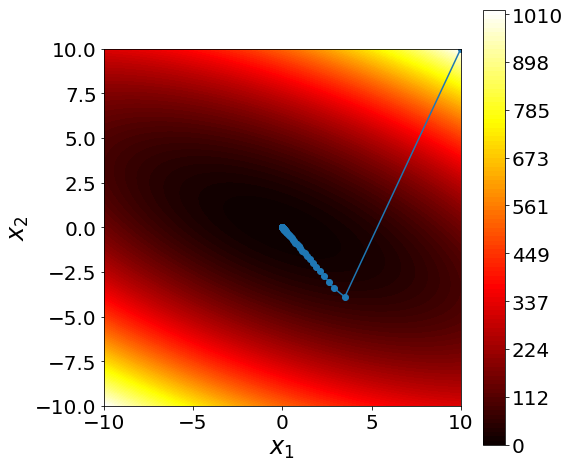

In [22]:
x0 = 10.0 * np.ones(2)
x_best, path = dfp_without_linesearch(
    x0, partial(quadratic, A=A),
    partial(quadratic_grad, A=A),
    0.1)
plot_path(partial(quadratic, A=A), path)

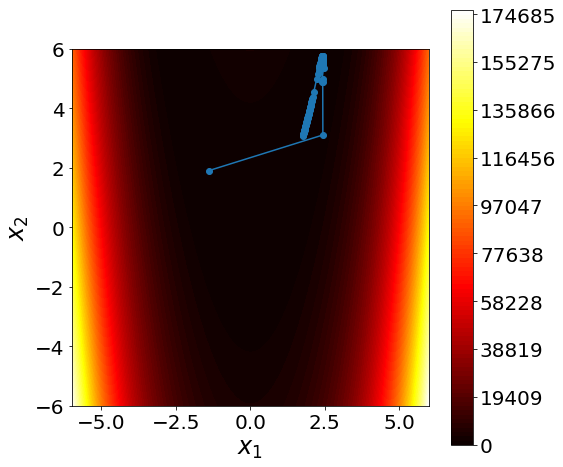

In [23]:
x0 = np.array([-1.4, 1.9])
x_best, path = dfp_without_linesearch(
    x0, rosenbrock, rosenbrock_grad, 0.1)
plot_path(rosenbrock, path, scale=6)

## Line Search

Line search determines the optimal step size $\alpha p$ given a direction $p$, that is, we minimize

$$\arg\min_\alpha f(x + \alpha p)$$

The direction is usually calculated based on the gradient and the approximation of the Hessian matrix. There are several line search methods. One of them is [backtracking line search](https://en.wikipedia.org/wiki/Backtracking_line_search) or Armijo line search.

Let us take a look at the following function and see what the line search from scipy does with it.

In [24]:
def poly1d(x):
    return x ** 2 - 5.0 * np.sin(x) ** 4 + x
def poly1d_grad(x):
    return 2 * x - 20.0 * np.sin(x) ** 3 * np.cos(x)

We assume that we already have an initial estimate and a search direction.

In [25]:
x0 = 4.0
p = -12.0

In [26]:
from scipy.optimize.linesearch import line_search_armijo
alpha, _, _ = line_search_armijo(poly1d, x0, p, poly1d_grad(x0), x0)

The following plot shows the initial point $x_0$ and search direction $p$ (black), $x + p$ (red), the found solution $x + \alpha p$ (green), and the function $f$.

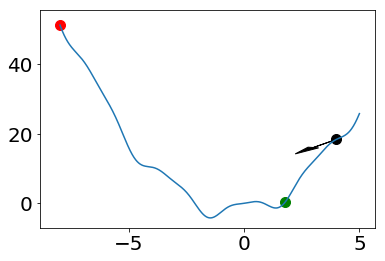

In [27]:
ax = subplot(111)
x_eval = linspace(-8, 5, 1001)
f_eval = poly1d(x_eval)
ax.plot(x_eval, f_eval)
ax.scatter(x0, poly1d(x0), c="k", s=100)
ax.scatter(x0 + p, poly1d(x0 + p), c="r", s=100)
ax.scatter(x0 + alpha * p, poly1d(x0 + alpha * p), c="g", s=100)
ax.arrow(x=x0, y=poly1d(x0), dx=-1, dy=-poly1d_grad(x0),
         head_width=0.5, head_length=2, fc='k', ec='k')

Now let us combine the BFGS approximation with this linesearch.

In [28]:
def bfgs(x0, fun, grad, grad_threshold=1e-30, max_iter=100, n_linesearch=10):
    x = np.copy(x0)
    path = [np.copy(x0)]

    n_dims = x.shape[0]
    B = np.eye(n_dims)

    old_f = None

    g = grad(x)
    for _ in range(max_iter):
        p = np.linalg.solve(B, -g)

        alpha, n_feval, old_f = line_search_armijo(fun, x, p, g, old_f)
        if alpha is None:  # found no solution that satisfies the conditions
            alpha = 1.0

        s = alpha * p
        x += s

        prev_g = g
        g = grad(x)
        if np.linalg.norm(g) <= grad_threshold:
            break

        if prev_g is not None:
            y = g - prev_g
            B += (np.outer(y, y) / np.dot(y, s) -
                  B.dot(s[:, np.newaxis]).dot(s[np.newaxis, :]).dot(B) / s.dot(B).dot(s))

        path.append(np.copy(x))

    return x, path

... and run it on a quadratic objective function.

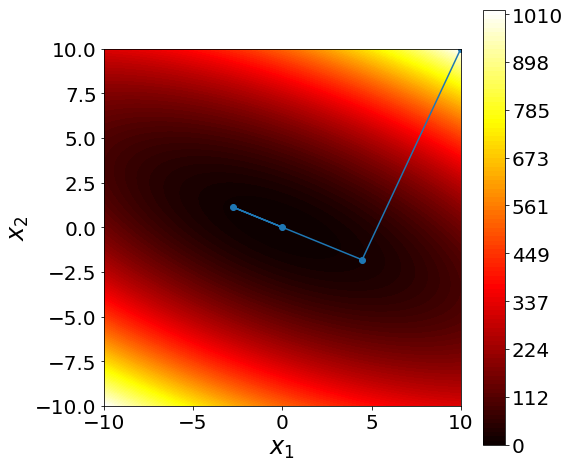

In [29]:
x0 = 10.0 * np.ones(2)
x_best, path = bfgs(
    x0, partial(quadratic, A=A),
    partial(quadratic_grad, A=A))
plot_path(partial(quadratic, A=A), path)

The error decreases rapidly.

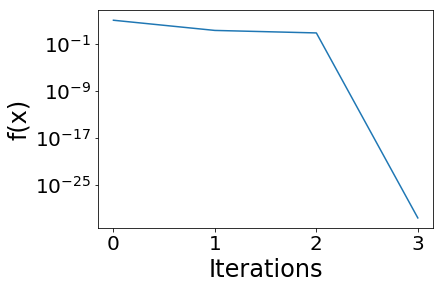

In [30]:
obj_path = [quadratic(p, A=A) for p in path]
xlabel("Iterations")
ylabel("f(x)")
semilogy(obj_path)

On the Rosenbrock function, the explored path even looks much smoother than with Newton's method, altough more steps are required.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in divide


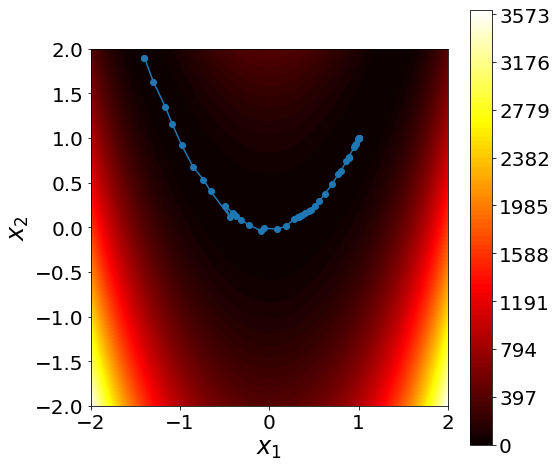

In [31]:
x0 = np.array([-1.4, 1.9])
x_best, path = bfgs(x0, rosenbrock, rosenbrock_grad)
plot_path(rosenbrock, path, scale=2)

Of course, we can modify Newton's method by adding linesearch to make the path smoother:

$$x_{t+1} = x_t - \alpha_t \nabla \nabla \left[ f(x_t) \right]^{-1} \nabla f(x_t)$$

In [32]:
def newton_with_linesearch(x0, fun, grad, hess,
                           grad_threshold=1e-10, max_iter=100):
    n_dims = len(x0)
    x = np.copy(x0)
    path = [np.copy(x0)]

    old_f = None

    for _ in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < grad_threshold:
            break
        H = hess(x)

        p = -np.linalg.inv(H).dot(g)

        alpha, n_feval, old_f = line_search_armijo(fun, x, p, g, old_f)
        if alpha is None:  # found no solution that satisfies the conditions
            alpha = 1.0

        x += alpha * p

        path.append(np.copy(x))
    return x, path

Using the exact Hessian is faster than BFGS for this objective function.

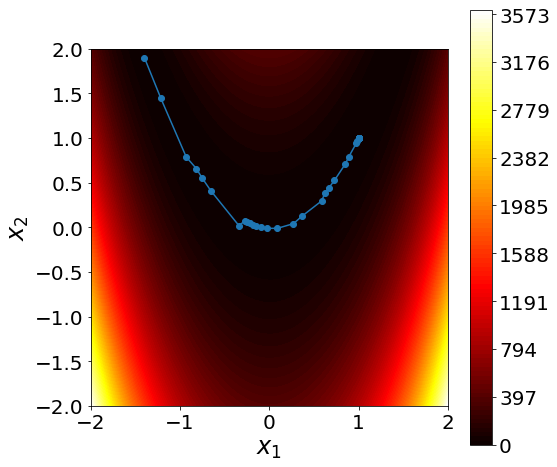

In [33]:
x0 = np.array([-1.4, 1.9])
x_best, path_newton = newton_with_linesearch(
    x0, rosenbrock, rosenbrock_grad, rosenbrock_hess)
plot_path(rosenbrock, path_newton, scale=2)

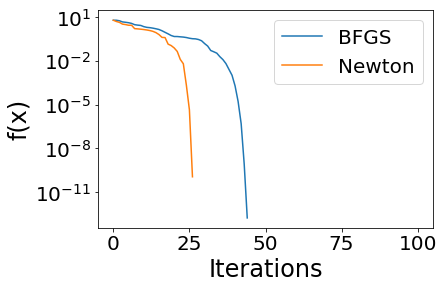

In [34]:
obj_path = [rosenbrock(p) for p in path]
xlabel("Iterations")
ylabel("f(x)")
semilogy([rosenbrock(p) for p in path], label="BFGS")
semilogy([rosenbrock(p) for p in path_newton], label="Newton")
legend(loc="best")

## Summary

Take Newton's method whenever it is possible. You might want to use line search for objectives that are not approximated well by quadratic functions.

It might be very expensive to compute the Hessian though. Consider for example the case of neural networks. There is an easy and efficient way to compute gradients. Computing the Hessian is not so straightforward and computationally more complex. It is possible though ([here](http://ieeexplore.ieee.org/document/6796780/) is a paper). It is also very expensive to compute the inverse of a Hessian: $\mathcal{O}(n^3)$.

BFGS is a good approximation of Newton's method. It guarantees that the approximation of the Hessian is positive definite and, hence, can deal with objectives that Newton's method cannot handle. It still has quadratic complexity though and has quadratic memory requirements.

What can we do if we do not have so much space to store the Hessian or its inverse? There are other methods with linear memory requirements. For example, [Conjugate Gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method), [limited-memory BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS), or gradient descent.

## Further Reading

* another tutorial can be found [here](http://aria42.com/blog/2014/12/understanding-lbfgs)
* a good book is [Numerical Optimization](http://www.springer.com/de/book/9780387303031) by Nocedal and Wright
* some lecture notes can be found [here](http://adl.stanford.edu/aa222/Lecture_Notes_files/chapter3_gradient.pdf)